In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import seaborn as sns

sys.setrecursionlimit(10000)

%matplotlib inline
init_notebook_mode(connected=True)

%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None # turn off SettingWithCopyWarning

np.random.seed(1234)
directory = os.path.join("..", "data", "ny") 


# Load Parcel Data

In [2]:
# names = ["event_id", "user_id", "location_id", "lon", "lat", "epoch_time"]
# data = pd.read_csv(
#     os.path.join("..", "data", "parcel_ass", "ny", "ass_events_no_filter.csv"), 
#     header = None, 
#     names = names
# )
# data.sort_values(['user_id', 'epoch_time'], inplace=True)

# # this data set doesn't have a day_id, so make it
# data['datetime'] = pd.to_datetime(data['epoch_time'], unit='s')
# start_date = data['datetime'].min().date()
# data['day_id'] = data['datetime'].sub(pd.Timestamp(start_date)).dt.days
# data = data.drop('datetime', axis=1)

# Visits  

Moshe created visits by _replacing tweets
occurring with the same hour and within 50 meters of each
other with a single effective tweet._ 

Note that the `epoch_time` column contains timestamps (not sure the timezone) with a milisecond resolution. We will use that column to create visits in a similar fashion that also incorporates the location of the tweet.

In [3]:
d = 0.05  # 50 m
t = 60**2  # number of s in one hr

def spherical_dist(pos1, r=6371):
    """
    return distance matrix in km
    
    https://stackoverflow.com/questions/19413259/efficient-way-to-calculate-distance-matrix-given-latitude-and-longitude-data-in
    """
    pos2 = np.array(pos1)
    pos1 = np.array(pos1)[:, None]
    pos1 = np.deg2rad(pos1)
    pos2 = np.deg2rad(pos2)
    cos_lat1 = np.cos(pos1[..., 0])
    cos_lat2 = np.cos(pos2[..., 0])
    cos_lat_d = np.cos(pos1[..., 0] - pos2[..., 0])
    cos_lon_d = np.cos(pos1[..., 1] - pos2[..., 1])
    return r * np.arccos(cos_lat_d - cos_lat1 * cos_lat2 * (1 - cos_lon_d))

def temporal_dist(times):
    """matrix of time differences"""
    times = np.array(times)
    return np.abs(np.subtract.outer(times, times))

def invert_dict(d): 
    """reverse a dictionary with list/set values"""
    inverse = dict() 
    for key in d: 
        for item in d[key]:
            inverse[item] = key
    return inverse

def set_visits(df):
    """
    :param df: pd.DataFrame for one user with <lat, lon, epoch_time> columns
    :return: same pd.DataFrame with a visit column containing integer visit id
    """
    # find groups of points that meet both the dist and time criteria for a visit
    distance_match = spherical_dist(df[['lat', 'lon']]) <= d
    time_match = temporal_dist(df['epoch_time']) <= t
    matches = distance_match & time_match
    groups = {}
    i = 0
    for row_i, row in enumerate(matches):
        v = list([i for i, is_true in enumerate(row) if is_true])
        if v not in groups.values():
            groups[i] = v
            i += 1
    df['visit'] = invert_dict(groups).values()
    return df

### Apply to the entire data set & save result

In [4]:
# data = data.groupby('user_id').apply(set_visits)
# data.to_csv(os.path.join(directory, "visits_no_filter.csv"), index=False)

# pop_deduped = data.drop_duplicates(['user_id', 'location_id', 'visit'])

In [6]:
# RAW DATA COUNTS
data = pd.read_csv(os.path.join(directory, "visits_no_filter.csv"))
print("Events:", data.shape[0])
print("Users:", data.user_id.nunique())
print("Avg:", data.shape[0] / data.user_id.nunique())

Events: 1162871
Users: 194224
Avg: 5.987267279018041


In [11]:
# VISIT DATA COUNTS
data_deduped = data.drop_duplicates(['user_id', 'location_id', 'visit'])
print("Events:", data_deduped.shape[0])
print("Users:", data_deduped.user_id.nunique())
print("Avg:", data_deduped.shape[0] / data_deduped.user_id.nunique())

Events: 989494
Users: 194224
Avg: 5.094602108905182


In [23]:
# DURATION OF OBSERVATION
print("({min}, {max}) days".format(min=min(data.day_id), max=max(data.day_id)))

(0, 242) days


## Format & filter for analysis

In [5]:
def sequential_filter_data(df, time_span='month', n_k=30):
    """
    Filter to users with at least n_k events in 2 sequential time_spans
    
    df: pd.DataFrame containing {user_id, day_id } columns 
    time_span: str in {'week', 'month', 'bimonth'}
    n_k: number of events a user must have in each time_span
    """
    t_vals = {
        'week': 7,
        'month': 30,
        'bimonth': 60,
    }
    t = t_vals.get(time_span)
    if t is None:
        return print("Enter a valid time_span... {'week', 'month', 'bimonth'}")

    # reset day id to start at 0
    df["day_id"] = df["day_id"] - df["day_id"].min()
    
    # calculate time_used ids
    df[time_span] = data.day_id // t
    
    # calc nevents in each time_span for each user & filter by min threshold
    counts = df.groupby(["user_id", time_span]).count()["event_id"]
    view = counts[counts >= n_k].reset_index()
    
    # join together to have a row for each user for a single time_span joined 
    # with the prior and next time_span
    lagged_view = pd.concat(
        [view, view.shift(1), view.shift(2)], 
        axis = 1
    )
    lagged_view.columns = list("next_" + view.columns) + \
        list(view.columns) + list("last_" + view.columns)
    
    # filter rows so that they only contain pairs where there is a sequential time_span present
    right_users = (lagged_view["user_id"] == lagged_view["next_user_id"]) | \
        (lagged_view["user_id"] == lagged_view["last_user_id"])
    sequential = ((lagged_view["next_"+time_span] - lagged_view[time_span]) == 1) | \
        ((lagged_view[time_span] - lagged_view["last_"+time_span]) == 1)
    filtered = lagged_view[right_users & sequential][["user_id", time_span, "event_id"]].reset_index(drop=True)
    
    # gather ids and valid weeks for the users that have survived the filtering
    user_time_dict = {-1 : []}
    for i, x in filtered.iterrows():
        user_id = x["user_id"]
        time = x[time_span]
        if user_id not in user_time_dict:
            user_time_dict[user_id] = []
        user_time_dict[user_id].append(time)
        
    # reduce the original data to be only valid events
    out = pd.merge(left=filtered, right=df, on=["user_id", time_span], how="left")    
    
    return out, user_time_dict


def create_mpp(df: pd.DataFrame, user_dict: dict):
    """create a dataframe contianing the data to be analyzed"""
    # get the user_ids that met the criteria in the first 2 months
    keep = []
    for uid, months in user_dict.items():
        if all(x in months for x in [0., 1.]):
            keep.append(uid)

    # create the mpp data frame
    mpp = df.loc[(df['user_id'].isin(keep)) & (df['month'].isin({0., 1.})),].reset_index()
    mpp['m'] = np.where(mpp['month'] == 0., 'a', 'b')
    
    # remap user id for easier handling
    user_dict = {}
    index = 1
    for ident in mpp.user_id.unique():
        if ident not in user_dict:
            user_dict[ident] = index
            index += 1

    mpp["uid"] = mpp.user_id.apply(lambda x: user_dict.get(x))
    
    return (
        mpp[['user_id', 'uid', 'm', 'lon', 'lat', 'location_id']].rename(index=str, columns={"user_id": "old_uid"}), 
        keep,
        user_dict, 
    )

In [6]:
time_span = 'month'
n_visits = 20

# filtered_visits, filtered_users = sequential_filter_data(
#     pop_deduped, time_span=time_span, n_k=n_visits
# )
# print("FILTERED VISITS")
# print("Users: ", filtered_visits['user_id'].nunique())  # 626
# print("Visits:", len(filtered_visits))  # 197,741

In [7]:
# mpp, keep, user_dict = create_mpp(filtered_visits, filtered_users)
# mpp.to_csv(os.path.join(directory, "mpp_visits_month0a_month1b_n20.csv"), index=False)

# pop_deduped['uid'] = pop_deduped.user_id.apply(lambda x: user_dict.get(x)).fillna(-1)
# pop_deduped = pop_deduped[['user_id', 'uid', 'lon', 'lat', 'location_id', 'visit', 'month', 'event_id']].rename(index=str, columns={"user_id": "old_uid"}) 
# pop_deduped.to_csv(os.path.join(directory, "visits_deduped.csv"), index=False)


In [37]:
data = pd.read_csv(os.path.join(directory, "visits_no_filter.csv"))
pop_deduped = pd.read_csv(os.path.join(directory, "visits_deduped.csv"))
mpp = pd.read_csv(os.path.join(directory, "mpp_visits_month0a_month1b_n20.csv"))

print("Events:", data.shape[0])
print("Visits:", pop_deduped.shape[0])
print("")
print("MPP DATA (at least {} visits in each of the first two {}s)".format(n_visits, time_span))
print("Users: ", mpp['uid'].nunique())
print("Visits:", len(mpp))


Events: 1162871
Visits: 989494



NameError: name 'n_visits' is not defined

In [9]:
n_users = mpp['uid'].nunique()
print("Number of visits")
print("----------------")
print("Month 1: ", sum(mpp.m == 'a'), "({} per user)".format(round(sum(mpp.m == 'a')/n_users, 1)))
print("Month 2: ", sum(mpp.m == 'b'), "({} per user)".format(round(sum(mpp.m == 'b')/n_users, 1)))


Number of visits
----------------
Month 1:  11951 (65.0 per user)
Month 2:  10985 (59.7 per user)


In [10]:
print(mpp.shape)
mpp.head()

(22936, 6)


,old_uid,uid,m,lon,lat,location_id
0,420363.0,1,a,-74.00633,40.74349,25195.0
1,420363.0,1,a,-74.00625,40.74340,25195.0
2,420363.0,1,a,-74.00641,40.74249,25164.0
3,420363.0,1,a,-74.00530,40.74520,25305.0
4,420363.0,1,a,-74.00628,40.74371,25195.0


In [11]:
print(pop_deduped.shape)
pop_deduped.head()

(989494, 8)


,old_uid,uid,lon,lat,location_id,visit,month,event_id
0,22.0,-1.0,-73.99706,40.73597,23615.0,0,6,6101502.0
1,22.0,-1.0,-73.99742,40.73084,4175.0,1,6,6689743.0
2,364.0,-1.0,-73.99800,40.74465,26603.0,0,7,6141394.0
3,418.0,-1.0,-73.99384,40.72405,4962.0,0,0,4563060.0
4,418.0,-1.0,-73.99351,40.73431,22212.0,1,0,3152670.0


## Visualize 

In [40]:
from kde.location_project.cmp import (
    calc_cmp,
    plot_scatter
)

plot_scatter(mpp=mpp, df=pop_deduped)

# Population Experiment

In [13]:
from kde.location_project.kde_2d import learn_nearest_neighbors_bandwidth, plot_kde
from kde.location_project.cmp import calc_cmp

### Compute bandwidths for the population data

In [14]:
# pts = pop_deduped.loc[:, ['lon', 'lat']].values
# pop_deduped['bw'] = learn_nearest_neighbors_bandwidth(pts, k=5, min_bw=0.05)
# pop_deduped.to_csv(os.path.join(directory, "visits_deduped_bw.csv"), index=False)

In [15]:
pop_deduped = pd.read_csv(os.path.join(directory, "visits_deduped_bw.csv"))
pop_kde_data = np.array(pop_deduped[['uid', 'lon', 'lat', 'bw']])

pop_deduped['bw'].describe()

count    989494.000000
mean          0.050089
std           0.002314
min           0.050000
25%           0.050000
50%           0.050000
75%           0.050000
max           0.300244
Name: bw, dtype: float64

## Same-source pairs

In [16]:
np.random.seed(1234)

# PARAMETERS
n_sim = 1000
k = 1  # which nearest neighbor to use in distance computation
users = mpp['uid'].unique()
same_src = []

for u in users:
    print("User", u)
    try:
        tmp = calc_cmp(
            mpp, pop_kde_data, userA=u, n_sim=n_sim, k=k
        )
        tmp['a'] = u
        tmp['b'] = u
        same_src.append(tmp)
    except:
        print("  Error!")
        continue
        
same = pd.DataFrame.from_dict(same_src)
same.to_csv(os.path.join(directory, "cmp_visits_emd_month0a_month1b_n20_same-src.csv"), index=False)


User 1
User 2
User 3
User 4
User 5
User 6
User 7
User 8
User 9
User 10
User 11
User 12
User 13
User 14
User 15
User 16
User 17
User 18
User 19
User 20
User 21
User 22
User 23
User 24
User 25
User 26
User 27
User 28
User 29
User 30
User 31
No other visits overlap with this pattern, using population only.
User 32
User 33
User 34
User 35
User 36
User 37
User 38
User 39
User 40
User 41
No other visits overlap with this pattern, using population only.
User 42
User 43
No other visits overlap with this pattern, using population only.
User 44
User 45
User 46
User 47
User 48
No other visits overlap with this pattern, using population only.
User 49
User 50
User 51
User 52
User 53
User 54
User 55
User 56
User 57
User 58
User 59
User 60
User 61
User 62
User 63
No other visits overlap with this pattern, using population only.
User 64
User 65
User 66
User 67
User 68
No other visits overlap with this pattern, using population only.
User 69
User 70
No other visits overlap with this pattern, using popu

## Different-source pairs (random sample)

In [17]:
# usr_sample1 = np.random.choice(users, 300, replace=True)  
# usr_sample2 = np.random.choice(users, 300, replace=True) 
# samp = np.hstack([np.atleast_2d(usr_sample1).T, np.atleast_2d(usr_sample2).T])
# samp[~(samp[:,0] == samp[:,1]), :][:250,:]

# diff_src = []
# for i in range(250):
#     print(i)
#     try:
#         tmp = calc_cmp(
#             mpp, pop_kde_data, userA=samp[i,0], userB=samp[i,1], n_sim=n_sim, k=k
#         )
#         tmp['a'] = samp[i,0]
#         tmp['b'] = samp[i,1]
#         diff_src.append(tmp)
#     except:
#         print("  Error!")
#         continue

# diff = pd.DataFrame.from_dict(diff_src)
# diff.to_csv(os.path.join(directory, "cmp_visits_emd_month0a_month1b_n20_diff-src.csv"), index=False)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
No other visits overlap with this pattern, using population only.
112
113
114
115
116
No other visits overlap with this pattern, using population only.
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
No other visits overlap with this pattern, using population only.
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
No other visits overlap with this pattern, using population only.
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
No other visits overlap with this pattern, usi

## Visualize Results

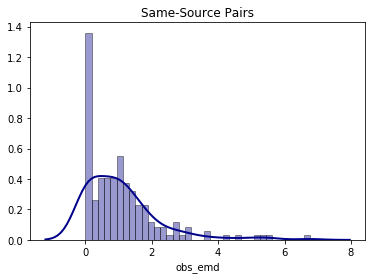

In [25]:
same = pd.read_csv(os.path.join(directory, "cmp_visits_emd_month0a_month1b_n20_same-src.csv"))
sns.distplot(
    same['obs_emd'], 
    hist=True, 
    kde=True, 
    bins=int(180/5), 
    color = 'darkblue', 
    hist_kws={'edgecolor':'black'},
    kde_kws={'linewidth': 2}
).set_title('Same-Source Pairs')
plt.show()

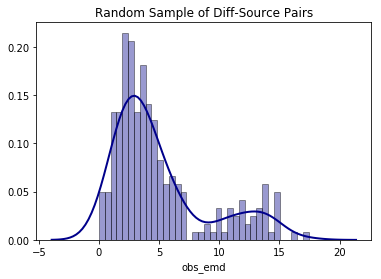

In [26]:
diff = pd.read_csv(os.path.join(directory, "cmp_visits_emd_month0a_month1b_n20_diff-src.csv"))
sns.distplot(
    diff['obs_emd'], 
    hist=True, 
    kde=True, 
    bins=int(180/5), 
    color = 'darkblue', 
    hist_kws={'edgecolor':'black'},
    kde_kws={'linewidth': 2}
).set_title('Random Sample of Diff-Source Pairs')
plt.show()

In [27]:
same.describe()

,a,b,cmp_emd,cmp_mean,cmp_median,obs_emd,obs_mean,obs_med
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000
mean,92.500000,92.500000,0.157891,0.211630,0.366027,1.063999,0.484637,0.280832
std,53.260367,53.260367,0.254442,0.294442,0.371601,1.143373,0.701136,0.618058
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,46.750000,46.750000,0.000000,0.000000,0.000000,0.160949,0.000632,0.000000
50%,92.500000,92.500000,0.029500,0.058000,0.243000,0.914699,0.317397,0.100097
75%,138.250000,138.250000,0.206500,0.375500,0.715750,1.465248,0.557531,0.290828
max,184.000000,184.000000,1.000000,1.000000,1.000000,6.761027,4.139984,5.822569


In [28]:
diff.describe()

,a,b,cmp_emd,cmp_mean,cmp_median,obs_emd,obs_mean,obs_med
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,90.784000,99.724000,0.685648,0.761016,0.791124,4.980167,3.225339,3.192891
std,52.873963,50.358073,0.304080,0.281907,0.262522,3.964861,3.364030,3.513121
min,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49.250000,56.250000,0.477000,0.622000,0.637500,2.228241,0.996830,0.803761
50%,90.500000,104.000000,0.763000,0.891500,0.907000,3.630212,1.966174,1.732505
75%,139.000000,143.750000,0.961000,0.992750,0.996750,6.131474,4.121347,4.250093
max,183.000000,184.000000,1.000000,1.000000,1.000000,17.437467,17.449785,17.840795


In [29]:
from sklearn.metrics import roc_auc_score

# label the points to compute the AUC... same-src has smaller cmp
same['inv_label'] = False
diff['inv_label'] = True
rslt = pd.concat([same, diff])
rslt['match'] = ~rslt.inv_label

# compute AUC
print("EMD:", round(roc_auc_score(rslt['inv_label'], rslt['cmp_emd']),4))
print("Mean IET:", round(roc_auc_score(rslt['inv_label'], rslt['cmp_mean']),4))
print("Median IET:", round(roc_auc_score(rslt['inv_label'], rslt['cmp_median']),4))

EMD: 0.8921
Mean IET: 0.8908
Median IET: 0.8169


In [30]:
def perf_measure(y_actual, y_hat):
    y_actual = list(y_actual)
    y_hat = list(y_hat)

    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    
    tpr = TP / (TP + FN)
    fpr = FP / (FP + TN)
    
    return (round(tpr, 3), round(fpr, 3))

In [31]:
print("EMD")
print("0.05:", perf_measure(rslt.match, rslt.cmp_emd <= 0.05))
print("0.001:", perf_measure(rslt.match, rslt.cmp_emd <= 0.001))

EMD
0.05: (0.543, 0.044)
0.001: (0.375, 0.032)


In [32]:
print("MEAN IED")
print("0.05:", perf_measure(rslt.match, rslt.cmp_mean <= 0.05))
print("0.001:", perf_measure(rslt.match, rslt.cmp_mean <= 0.001))

MEAN IED
0.05: (0.495, 0.036)
0.001: (0.364, 0.024)


In [33]:
print("MEDIAN IED")
print("0.05:", perf_measure(rslt.match, rslt.cmp_median <= 0.05))
print("0.001:", perf_measure(rslt.match, rslt.cmp_median <= 0.001))

MEDIAN IED
0.05: (0.375, 0.032)
0.001: (0.299, 0.024)


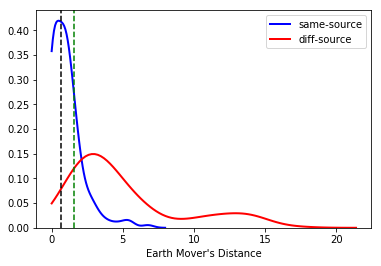

In [45]:
ax = sns.kdeplot(
    same['obs_emd'], 
    color = 'blue',
    lw=2,
    clip=(0,100),
    label='same-source'
)
sns.kdeplot(
    diff['obs_emd'], 
    color = 'red',
    lw=2,
    clip=(0,100),
    label='diff-source'
)
plt.axvline(0.674811, 0, 1, color='black', ls='dashed')  # User 1 same
plt.axvline(1.596498, 0, 1, color='green', ls='dashed')  # Users {40, 156}
ax.set(xlabel="Earth Mover's Distance")
plt.show()

In [40]:
from kde.location_project.cmp import plot_scatter

u = 1

print(same['cmp_emd'].loc[same.a == u])
print(same['obs_emd'].loc[same.a == u])
plot_scatter(mpp=mpp, df=pop_deduped, uid=u)

0    0.003
Name: cmp_emd, dtype: float64
0    0.674811
Name: obs_emd, dtype: float64


In [41]:
diff.head()

,a,b,cmp_emd,cmp_mean,cmp_median,obs_emd,obs_mean,obs_med,inv_label
0,16,148,0.399,0.874,0.924,1.596498,0.514090,0.336110,True
1,161,24,0.636,1.000,1.000,2.833496,1.253749,1.253749,True
2,87,111,0.565,0.974,0.974,3.080639,1.408544,1.408544,True
3,170,70,0.702,0.702,0.702,2.651084,2.647604,2.647604,True
4,40,156,0.631,0.632,0.524,3.617313,3.619475,3.903802,True


In [44]:
u1 = 16
u2 = 148

print(diff['cmp_emd'].loc[(diff.a == u1) & (diff.b == u2)])
print(diff['obs_emd'].loc[(diff.a == u1) & (diff.b == u2)])

plot_scatter(mpp=mpp, df=pop_deduped, uid=u1, uidB=u2)

0    0.399
Name: cmp_emd, dtype: float64
0    1.596498
Name: obs_emd, dtype: float64
